In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import re
from pathlib import Path

In [166]:
from get_to_know_data import load_data, summarize_data

In [167]:
# get a list of all files in directory
output_dir = Path("../data_sync/outputs/raw outputs")
data_files = list(output_dir.glob("*.csv"))
print(len(data_files))

25


In [168]:
file = data_files[0]
print(f"Processing file: {file}")
data = load_data(file)
print(data.head())

Processing file: ../data_sync/outputs/raw outputs/BIA24-17_WR_merged_with_gear.csv
   sessionid                 tt_s  distance_m  slope_pct  speed_kmph  power_w  \
0       2426  2024-09-11 07:26:19       80.34        0.0        24.2    404.0   
1       2426  2024-09-11 07:26:20       87.66        0.0        24.0    404.0   
2       2426  2024-09-11 07:26:21       94.96        0.0        24.0    376.0   
3       2426  2024-09-11 07:26:22      101.85        0.0        24.0    340.0   
4       2426  2024-09-11 07:26:23      108.19        0.0        24.4    317.0   

   heartrate_bpm  frequency_ppm  cycle  thrust_left_ms  ...  ns1:BuildMajor8  \
0            0.0           72.0    7.0           230.0  ...              0.0   
1            0.0           70.0    8.0           200.0  ...              0.0   
2            0.0           70.0    9.0           180.0  ...              0.0   
3            0.0           70.0   10.0           170.0  ...              0.0   
4            0.0           68.

In [169]:
# Print all column names
print("Column names:")
print(data.columns.tolist())
print(f"\nTotal number of columns: {len(data.columns)}")

Column names:
['sessionid', 'tt_s', 'distance_m', 'slope_pct', 'speed_kmph', 'power_w', 'heartrate_bpm', 'frequency_ppm', 'cycle', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'treadmill_force_n', 'altitude_m', 'latitude_deg', 'longitude_deg', 'usernote = BIA24-17WR', 'Sport', 'ns1:Id', 'StartTime', 'ns1:TotalTimeSeconds', 'ns1:DistanceMeters', 'ns1:MaximumSpeed', 'ns1:Calories', 'ns1:Value', 'ns1:Value2', 'ns1:Intensity', 'ns1:TriggerMethod', 'ns1:Time', 'ns1:AltitudeMeters', 'ns1:DistanceMeters3', 'ns1:Value4', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'ns2:AvgSpeed', 'ns2:AvgRunCadence', 'ns2:MaxRunCadence', 'ns2:AvgWatts', 'ns2:MaxWatts', 'ns1:Name', 'ns1:UnitId', 'ns1:ProductID', 'ns1:VersionMajor', 'ns1:VersionMinor', 'ns1:BuildMajor', 'ns1:BuildMinor', 'ns1:Name5', 'ns1:VersionMajor6', 'ns1:VersionMinor7', 'ns1:BuildMajor8', 'ns1:BuildMinor9', 'ns1:La

In [170]:
info_columns = ['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport'] 
feature_columns_pole_data = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']

In [171]:
def plot_histogram_with_gear_label(df, column):
    """Plot a histogram of a specified column in the DataFrame, separated by gear."""
    plt.figure(figsize=(10, 6))
    
    # Get unique gear values
    gears = df['Gear'].dropna().unique()
    
    # Use a colormap with more distinct colors
    colors = plt.cm.tab10(range(len(gears)))
    
    # Plot histogram for each gear
    for i, gear in enumerate(gears):
        gear_data = df[df['Gear'] == gear][column].dropna()
        plt.hist(gear_data, bins=30, alpha=0.6, label=f'Gear {gear}', color=colors[i])
    
    plt.title(f'Histogram of {column} by Gear')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()    
    plt.show()

In [172]:
def data_overview(df):
    # Select only relevant columns
    selected_columns = info_columns + feature_columns_pole_data + feature_columns_gnss
    df = df[selected_columns]
    summarize_data(df)
    # print unique gear values
    print("Unique gear values:", df['Gear'].unique())
    print("Gear value counts:")
    print(df['Gear'].value_counts())
    for col in feature_columns_pole_data + feature_columns_gnss:
        plot_histogram_with_gear_label(df, col)

In [173]:
def merge_data_to_one_df(data_files=data_files):
    merged_df = pd.DataFrame()
    for file in data_files:
        print(f"Processing file: {file}")
        data = load_data(file)
        merged_df = pd.concat([merged_df, data], ignore_index=True)
    return merged_df

In [174]:
def find_files_with_nans(data_files=data_files):
    files_with_nans = []
    for file in data_files:
        selected_columns = info_columns + feature_columns_pole_data + feature_columns_gnss
        data = load_data(file)
        try:
            data = data[selected_columns]
        except KeyError as e:
            print(f"KeyError for file {file}: {e}")
            continue
        if data.isnull().values.any():
            files_with_nans.append(file)
    return files_with_nans

In [175]:
find_files_with_nans(data_files)

[]

In [176]:
def find_files_with_gear_6(data_files=data_files):
    files_with_6 = []
    for file in data_files:
        selected_columns = info_columns + feature_columns_pole_data + feature_columns_gnss
        data = load_data(file)
        try:
            data = data[selected_columns]
        except KeyError as e:
            print(f"KeyError for file {file}: {e}")
            continue
        if '6.0' in data['Gear'].unique():
            files_with_6.append(file)
    return files_with_6

In [177]:
find_files_with_gear_6(data_files)

[]

In [178]:
merge_data_to_one_df()

Processing file: ../data_sync/outputs/raw outputs/BIA24-17_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-8_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-7_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-18_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-18_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-7_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-8_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-3_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-22_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-22_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-3_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-4_WR_merged_with_gear.csv
Processing 

,sessionid,tt_s,distance_m,slope_pct,speed_kmph,power_w,heartrate_bpm,frequency_ppm,cycle,thrust_left_ms,...,usernote = BIA24-4NR,usernote = BIA24-9WR,usernote = BIA24-19NR,usernote = BIA24-19WR,usernote = BIA24-5NR,usernote = BIA24-15WR,usernote = BIA24-15NR,usernote = BIA24-5WR,usernote = BIA24-20WR,usernote = BIA24-20NR
0,2426,2024-09-11 07:26:19,80.34,0.0,24.2,404.0,0.0,72.0,7.0,230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2426,2024-09-11 07:26:20,87.66,0.0,24.0,404.0,0.0,70.0,8.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2426,2024-09-11 07:26:21,94.96,0.0,24.0,376.0,0.0,70.0,9.0,180.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2426,2024-09-11 07:26:22,101.85,0.0,24.0,340.0,0.0,70.0,10.0,170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2426,2024-09-11 07:26:23,108.19,0.0,24.4,317.0,0.0,68.0,12.0,130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29192,2466,2024-09-18 08:30:25,7498.73,0.0,18.2,45.0,0.0,0.0,964.0,180.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29193,2466,2024-09-18 08:30:26,7503.39,0.0,17.0,8.0,0.0,0.0,964.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29194,2466,2024-09-18 08:30:27,7507.95,0.0,15.4,0.0,0.0,0.0,964.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29195,2466,2024-09-18 08:30:28,7511.44,0.0,14.7,0.0,0.0,0.0,964.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Processing file: ../data_sync/outputs/raw outputs/BIA24-17_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-8_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-7_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-18_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-18_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-7_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-8_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-3_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-22_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-22_NR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-3_WR_merged_with_gear.csv
Processing file: ../data_sync/outputs/raw outputs/BIA24-4_WR_merged_with_gear.csv
Processing 

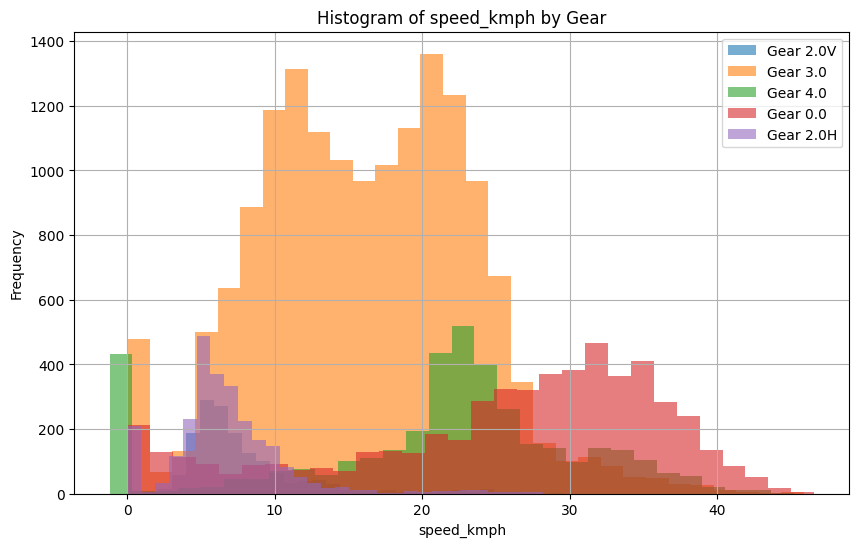

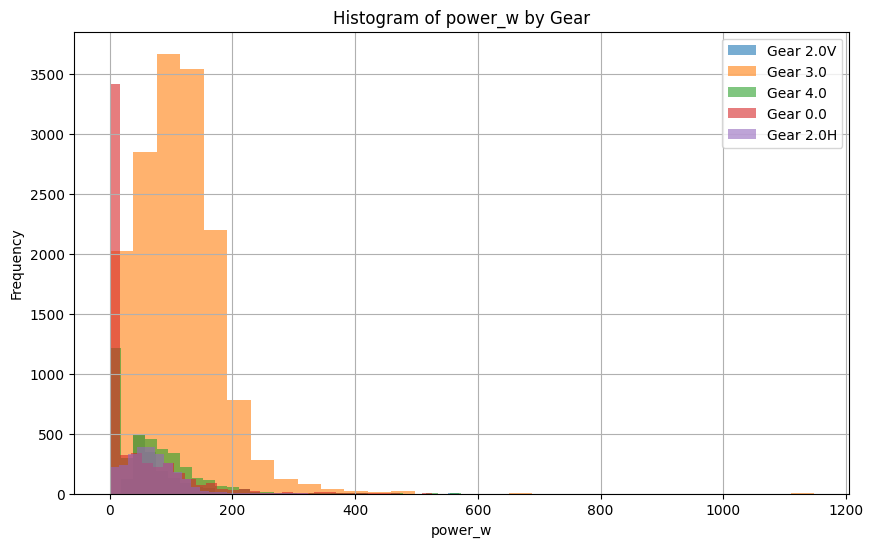

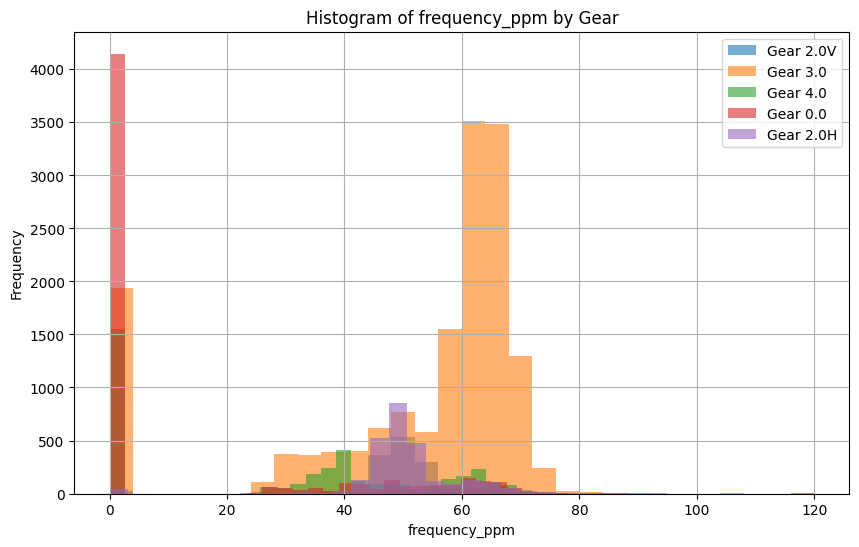

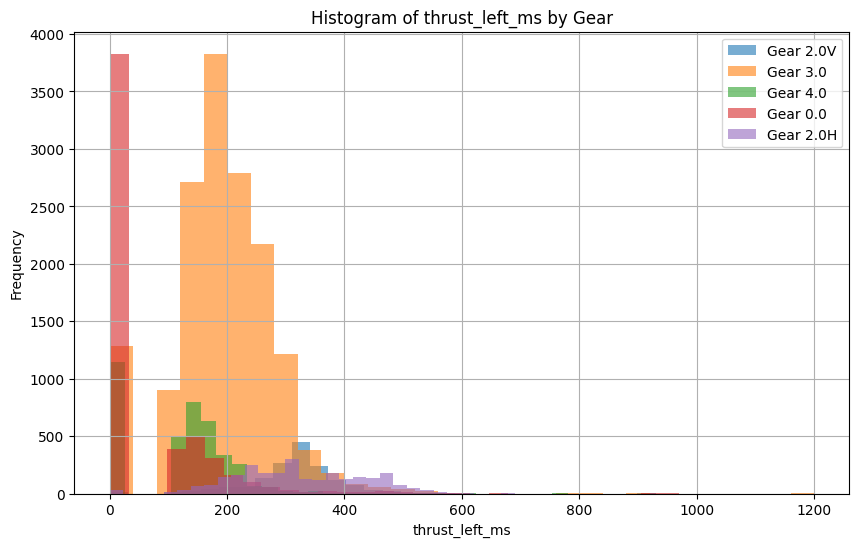

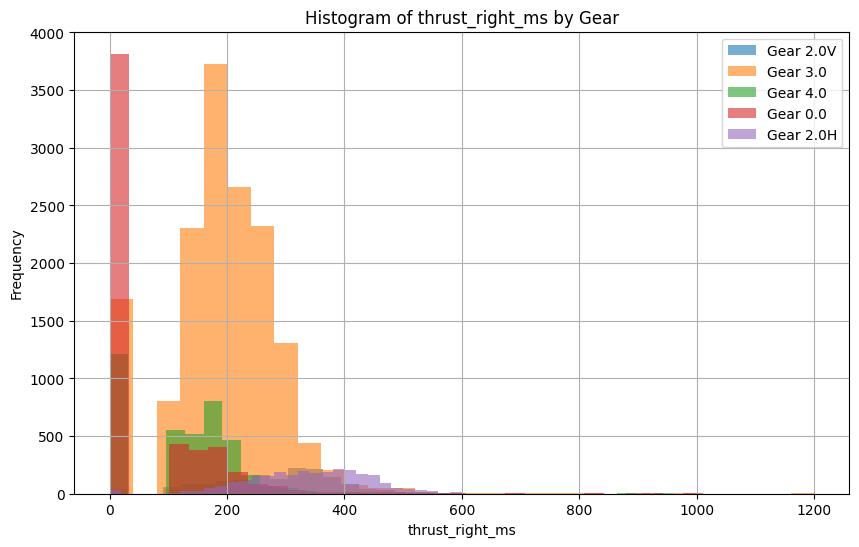

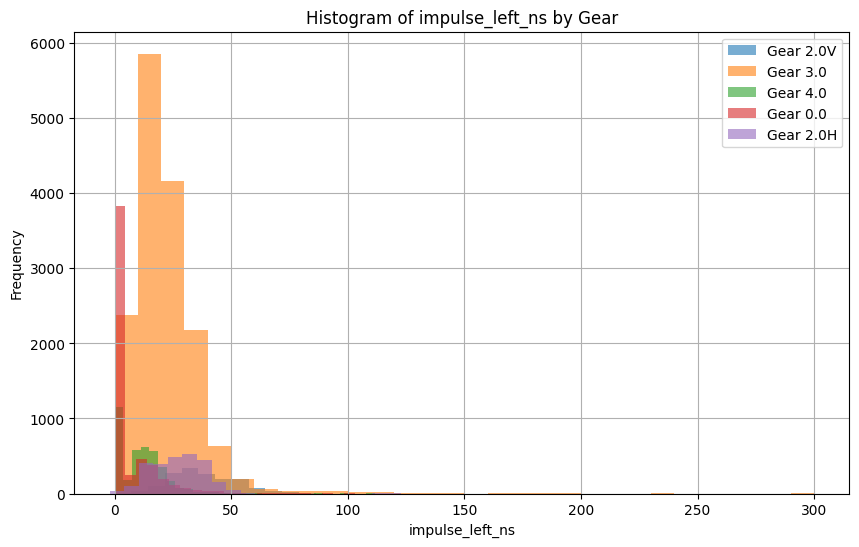

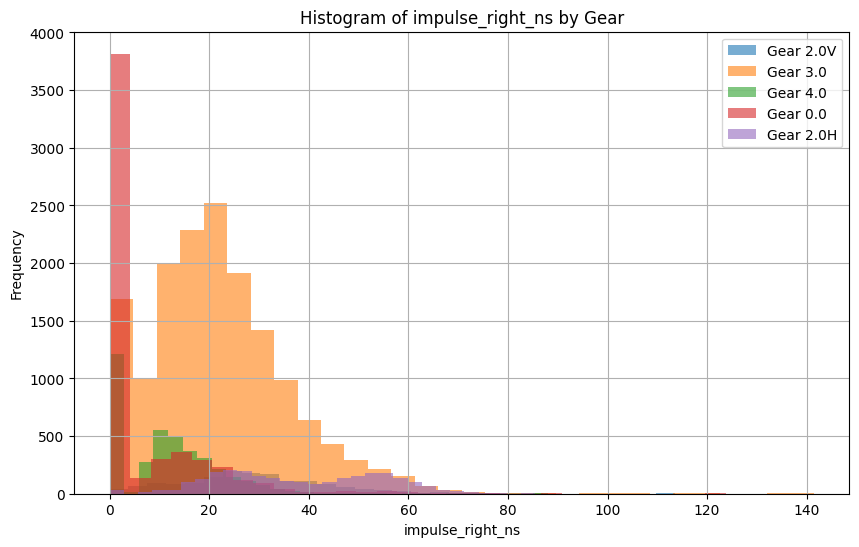

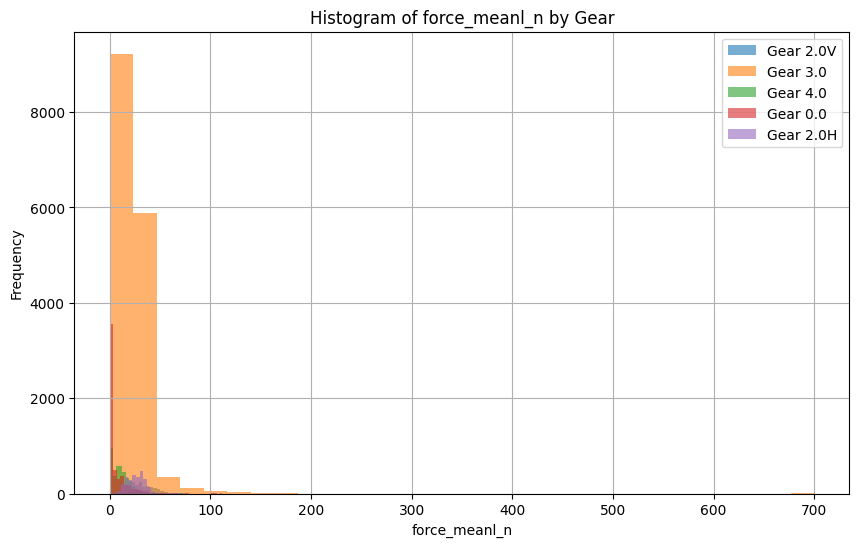

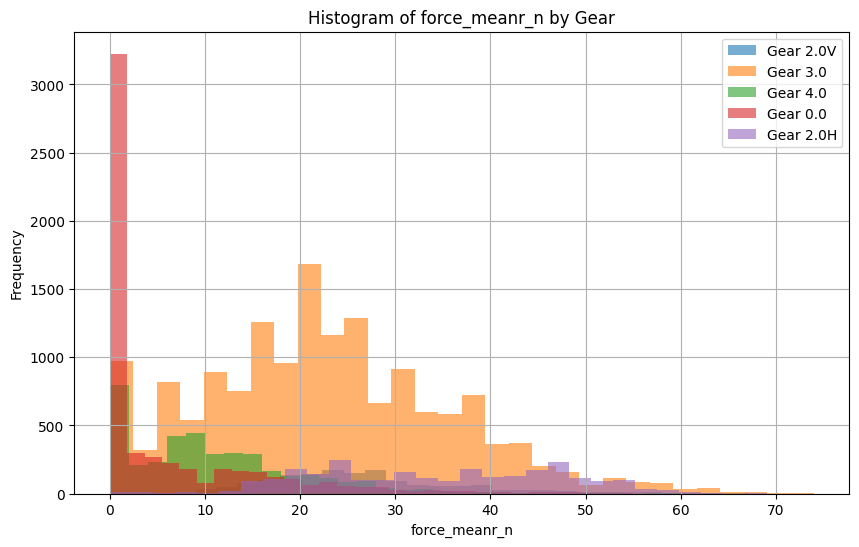

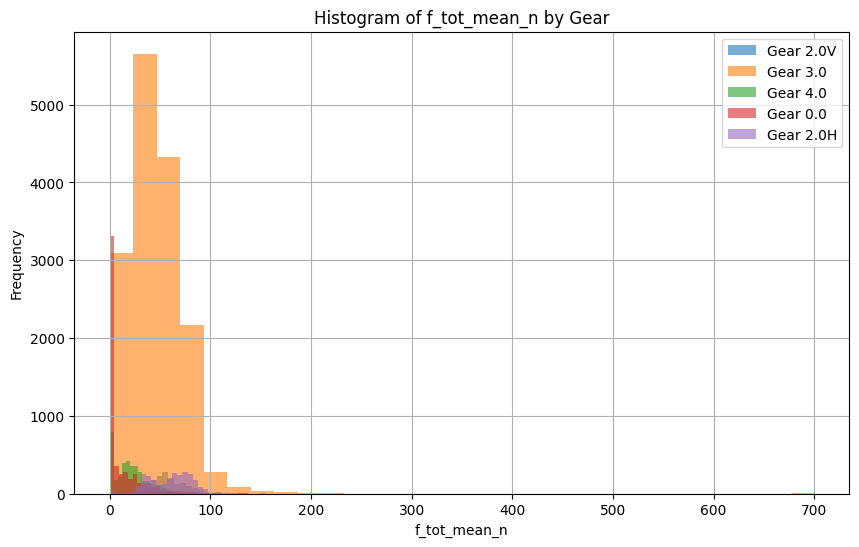

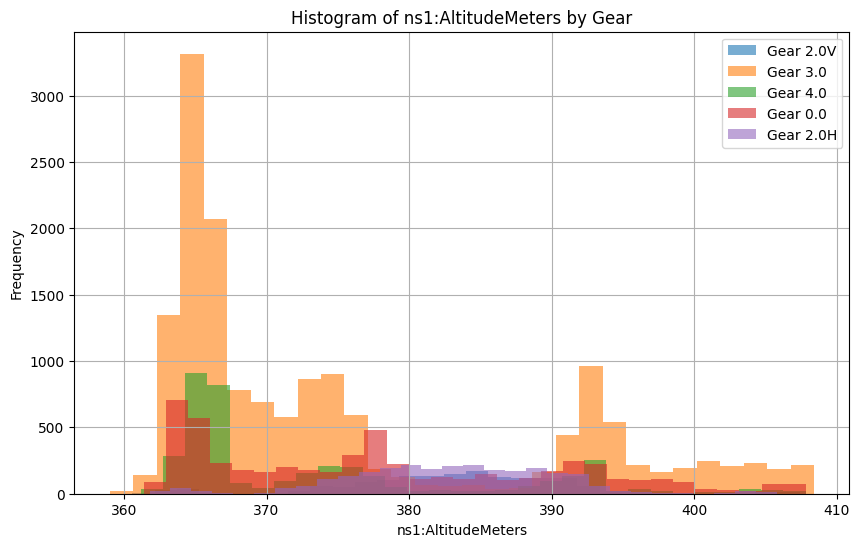

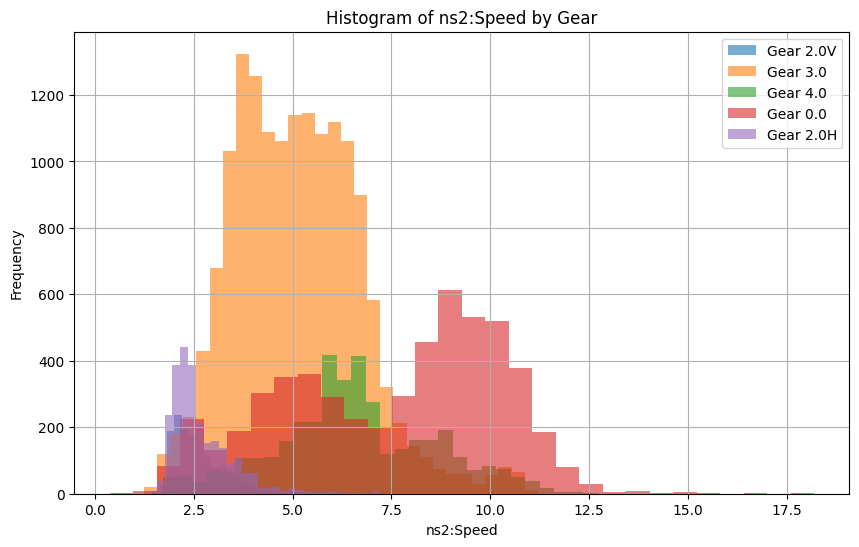

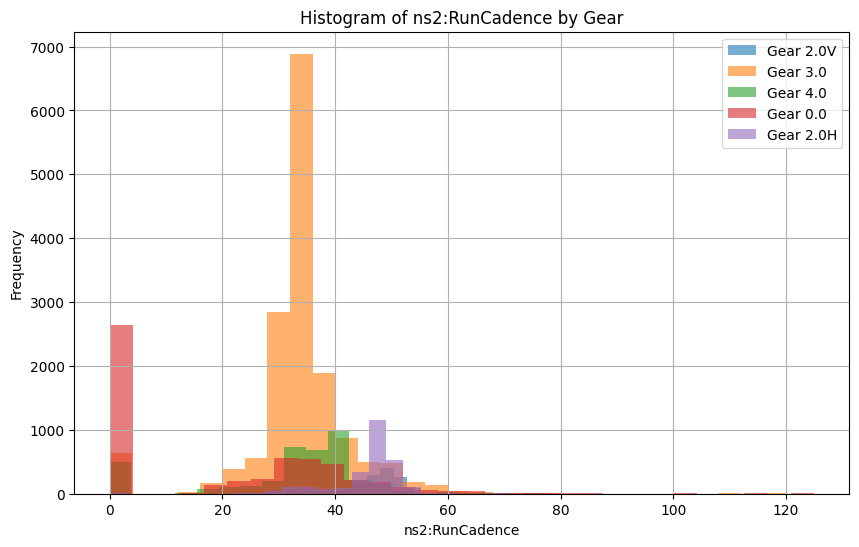

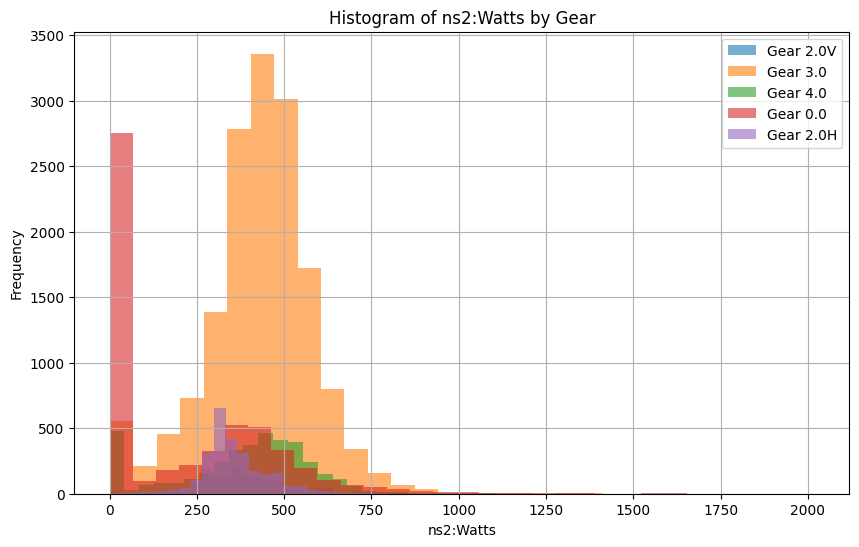

In [179]:
data_overview(merge_data_to_one_df())

In [197]:
# train and validation set files
train_val_set = Path("../data_sync/outputs/Training_and_validation_set")
train_val_files = list(train_val_set.glob("*.csv"))
print(len(train_val_files))

21


In [198]:
# test set files
test_set = Path("../data_sync/outputs/Test_set")
test_files = list(test_set.glob("*.csv"))
print(len(test_files))

4


In [199]:
info_columns

['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport']

In [200]:
feature_columns_gnss

['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']

In [201]:
feature_columns_pole_data

['speed_kmph',
 'power_w',
 'frequency_ppm',
 'thrust_left_ms',
 'thrust_right_ms',
 'impulse_left_ns',
 'impulse_right_ns',
 'force_meanl_n',
 'force_meanr_n',
 'f_tot_mean_n']

In [202]:
def extract_mean_and_std(train_val_files=train_val_files):
    all_files = train_val_files
    means = {}
    stds = {}
    for col in feature_columns_pole_data + feature_columns_gnss:
        col_values = []
        for file in all_files:
            data = load_data(file)
            if col in data.columns:
                col_values.extend(data[col].dropna().values)
        means[col] = np.mean(col_values)
        stds[col] = np.std(col_values)
    return means, stds


In [187]:
mean, std = extract_mean_and_std()
print(mean)
print(std)

{'speed_kmph': np.float64(17.03416007179571), 'power_w': np.float64(81.86464877213021), 'frequency_ppm': np.float64(40.29574936770825), 'thrust_left_ms': np.float64(169.4521497919556), 'thrust_right_ms': np.float64(168.228359304887), 'impulse_left_ns': np.float64(18.307093905523374), 'impulse_right_ns': np.float64(18.52798808843926), 'force_meanl_n': np.float64(18.469690788936934), 'force_meanr_n': np.float64(18.347638084359957), 'f_tot_mean_n': np.float64(36.817328873296894), 'ns1:AltitudeMeters': np.float64(376.5660031276571), 'ns2:Speed': np.float64(5.364671044098452), 'ns2:RunCadence': np.float64(32.67785755078731), 'ns2:Watts': np.float64(371.40531940931714)}
{'speed_kmph': np.float64(9.836632499127749), 'power_w': np.float64(70.40739643543561), 'frequency_ppm': np.float64(26.337508378749927), 'thrust_left_ms': np.float64(119.22650933212502), 'thrust_right_ms': np.float64(121.36457920366361), 'impulse_left_ns': np.float64(16.893693328902664), 'impulse_right_ns': np.float64(15.7207

In [208]:
selected_columns = info_columns + feature_columns_pole_data + feature_columns_gnss
feature_columns = ['speed_kmph',
                    'power_w',
                    'frequency_ppm',
                    'thrust_left_ms',
                    'thrust_right_ms',
                    'impulse_left_ns',
                    'impulse_right_ns',
                    'force_meanl_n',
                    'force_meanr_n',
                    'f_tot_mean_n',
                    'ns2:Speed',
                    'ns2:RunCadence',
                    'ns2:Watts',
                    'ns1:AltitudeMeters'
                ]


In [209]:
def normalize_files(files, mean, std, selected_columns=selected_columns, feature_columns=feature_columns):
    for file in files:
        data = load_data(file)
        data = data[selected_columns]
        for col in feature_columns:
            if col in data.columns:
                data[col] = (data[col] - mean[col]) / std[col]
        # Save normalized data back to CSV
        data.to_csv(file, index=False)

In [210]:
normalize_files(train_val_files, mean, std)
normalize_files(test_files, mean, std)